# UNet
* Biomedical 분야에서 이미지 분할을 목적으로 만을어진 End-to-End 방식의 Fully-Convolution Network 기반의 모델  

### End-to-End
* '종단간'이라는 뜻(처음부터 끝까지)
* 입력에서 출력까지 '파이프라인 네트워크' 없이 한 번에 처리한다는 뜻

### End-to-End Deep Learning
* 신경망에 너무 많은 계층의 노드가 있거나, 메모리가 부족할 경우 사용할 수 없음
* 문제가 복잡할 수록 '전체 네트워크'를 '파이프라인 네트워크'로 쪼개서 해결하는 것이 더 효율적일 때도 있음

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0

import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.losses as losses
from glob import glob


os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [9]:
import tensorflow.keras.losses as losses

def iou(y_true, y_pred):
    smooth = 0.
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union + smooth)
    return score
    

def dice_coef(y_true, y_pred):
    smooth = 0.
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) +  tf.reduce_sum(y_pred) + smooth)
    
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 1.*losses.binary_crossentropy(y_true, y_pred) + 1.*dice_loss(y_true, y_pred)

    return loss

In [10]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1* size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask

In [11]:
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name']. \
                          isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png', cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            if self.mode == 'train':
#                 image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
            
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')
            
#             label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [12]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=128,
    shuffle=True)


In [1]:
pip install keras-unet

  Using cached keras_unet-0.1.2-py3-none-any.whl (16 kB)
Note: you may need to restart the kernel to use updated packages.


In [13]:
# attention : 데이터가 긴 형태는 품질이 떨어지는 현상이 발생 -> 보정 -> Decoder에 전달

from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(128,128,3),
    use_batch_norm = True,
    upsample_mode = 'deconv',
    dropout_type='spatial',
    use_attention=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='sigmoid'
)

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[iou])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 128, 128, 64  1728        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 64  256        ['conv2d_31[0][0]']              
 ormalization)                  )                                                           

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['iou'], label='train')
plt.plot(history['val_iou'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('iou')
plt.title("IoU")
plt.show()

In [14]:
for images, masks in valid_generator:
    break

In [15]:
preds = model.predict(images)

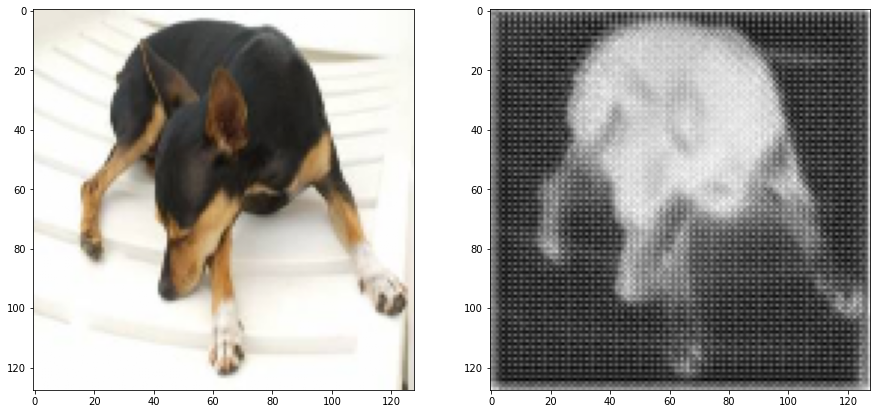

In [16]:
import random

idx = random.choice(range(len(preds)))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(images[idx, ...])
plt.subplot(1, 2, 2)
plt.imshow(preds[idx, ..., 0], cmap='gray')